# High School Timetabling: Production Scale

This notebook demonstrates LumiX's capability to handle **realistic large-scale problems** efficiently while introducing **room type constraints** for specialized classrooms.

## What's New in This Notebook

- **3x Larger Scale**: 15 teachers, 12 classrooms, 12 classes, 80 lectures
- **Room Type Constraints**: Lab subjects require LAB rooms, PE requires GYM
- **Cached Compatibility Checker**: Efficient filtering for capacity AND room type
- **Multiple Departments**: Math/Science (8 teachers), Humanities (5), PE (2)
- **8 Periods Per Day**: More realistic scheduling

## Scale Comparison

| Metric | Basic (Notebook 12) | This Notebook |
|--------|---------------------|---------------|
| Teachers | 5 | 15 |
| Classrooms | 4 | 12 (8 regular, 3 labs, 1 gym) |
| Classes | 4 | 12 (4 grades × 3 each) |
| Lectures | 20 | 86 |
| Timeslots | 30 | 40 (8 periods/day) |
| Preferences | 7 | 22 |

## 1. Setup and Imports

In [1]:
# Standard library
import time
from typing import Tuple, Dict

# Database
from sqlalchemy import create_engine, Column, Integer, String, Boolean, ForeignKey
from sqlalchemy.orm import declarative_base, sessionmaker, Session

# Visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# LumiX
from lumix import LXConstraint, LXLinearExpression, LXModel, LXOptimizer, LXVariable
from lumix.indexing import LXIndexDimension

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

Base = declarative_base()

## 2. Define ORM Models with Room Types

In [2]:
class Teacher(Base):
    __tablename__ = 'teachers'
    id = Column(Integer, primary_key=True)
    name = Column(String(100), nullable=False)
    work_years = Column(Integer, default=0)
    department = Column(String(50))


class Classroom(Base):
    __tablename__ = 'classrooms'
    id = Column(Integer, primary_key=True)
    name = Column(String(50), nullable=False)
    capacity = Column(Integer, nullable=False)
    room_type = Column(String(20), default="REGULAR")  # REGULAR, LAB, GYM


class SchoolClass(Base):
    __tablename__ = 'school_classes'
    id = Column(Integer, primary_key=True)
    name = Column(String(20), nullable=False)
    size = Column(Integer, nullable=False)
    grade = Column(Integer)


class Subject(Base):
    __tablename__ = 'subjects'
    id = Column(Integer, primary_key=True)
    name = Column(String(50), nullable=False)
    requires_lab = Column(Boolean, default=False)


class TimeSlot(Base):
    __tablename__ = 'timeslots'
    id = Column(Integer, primary_key=True)
    day_of_week = Column(Integer, nullable=False)
    period = Column(Integer, nullable=False)
    day_name = Column(String(20), nullable=False)


class Lecture(Base):
    __tablename__ = 'lectures'
    id = Column(Integer, primary_key=True)
    subject_id = Column(Integer, ForeignKey('subjects.id'), nullable=False)
    teacher_id = Column(Integer, ForeignKey('teachers.id'), nullable=False)
    class_id = Column(Integer, ForeignKey('school_classes.id'), nullable=False)


class TeacherPreference(Base):
    __tablename__ = 'teacher_preferences'
    id = Column(Integer, primary_key=True)
    teacher_id = Column(Integer, ForeignKey('teachers.id'), nullable=False)
    preference_type = Column(String(20), nullable=False)  # DAY_OFF, SPECIFIC_TIME
    day_of_week = Column(Integer, nullable=True)
    lecture_id = Column(Integer, nullable=True)
    timeslot_id = Column(Integer, nullable=True)


print("ORM models defined with room types")

ORM models defined with room types


## 3. Create and Populate Large-Scale Database

In [3]:
# Create database
engine = create_engine('sqlite:///:memory:', echo=False)
Base.metadata.create_all(engine)
SessionLocal = sessionmaker(bind=engine)
session = SessionLocal()

# TEACHERS (15 total across 3 departments)
teachers_data = [
    # Math/Science Department (8 teachers)
    Teacher(id=1, name="Dr. Emily Watson", work_years=18, department="Math/Science"),
    Teacher(id=2, name="Prof. Michael Chen", work_years=15, department="Math/Science"),
    Teacher(id=3, name="Dr. Sarah Johnson", work_years=12, department="Math/Science"),
    Teacher(id=4, name="Mr. David Kim", work_years=8, department="Math/Science"),
    Teacher(id=5, name="Ms. Rachel Green", work_years=4, department="Math/Science"),
    Teacher(id=6, name="Dr. James Wilson", work_years=20, department="Math/Science"),
    Teacher(id=7, name="Ms. Lisa Anderson", work_years=6, department="Math/Science"),
    Teacher(id=8, name="Mr. Robert Taylor", work_years=10, department="Math/Science"),
    # Humanities Department (5 teachers)
    Teacher(id=9, name="Prof. Jennifer Brown", work_years=16, department="Humanities"),
    Teacher(id=10, name="Ms. Amanda White", work_years=7, department="Humanities"),
    Teacher(id=11, name="Mr. Christopher Lee", work_years=3, department="Humanities"),
    Teacher(id=12, name="Dr. Patricia Martinez", work_years=14, department="Humanities"),
    Teacher(id=13, name="Ms. Michelle Garcia", work_years=5, department="Humanities"),
    # PE Department (2 teachers)
    Teacher(id=14, name="Coach John Davis", work_years=11, department="PE"),
    Teacher(id=15, name="Coach Maria Rodriguez", work_years=9, department="PE"),
]
session.add_all(teachers_data)

# CLASSROOMS (12 total: 8 regular, 3 labs, 1 gym)
classrooms_data = [
    # Regular classrooms (8)
    Classroom(id=1, name="Room 101", capacity=32, room_type="REGULAR"),
    Classroom(id=2, name="Room 102", capacity=32, room_type="REGULAR"),
    Classroom(id=3, name="Room 201", capacity=30, room_type="REGULAR"),
    Classroom(id=4, name="Room 202", capacity=30, room_type="REGULAR"),
    Classroom(id=5, name="Room 301", capacity=28, room_type="REGULAR"),
    Classroom(id=6, name="Room 302", capacity=28, room_type="REGULAR"),
    Classroom(id=7, name="Room 401", capacity=35, room_type="REGULAR"),
    Classroom(id=8, name="Room 402", capacity=35, room_type="REGULAR"),
    # Science labs (3)
    Classroom(id=9, name="Chemistry Lab", capacity=32, room_type="LAB"),
    Classroom(id=10, name="Physics Lab", capacity=32, room_type="LAB"),
    Classroom(id=11, name="Biology Lab", capacity=30, room_type="LAB"),
    # Gymnasium (1)
    Classroom(id=12, name="Main Gym", capacity=50, room_type="GYM"),
]
session.add_all(classrooms_data)

# SCHOOL CLASSES (12 total: 4 grades x 3 classes each)
classes_data = [
    # Grade 9
    SchoolClass(id=1, name="9A", size=28, grade=9),
    SchoolClass(id=2, name="9B", size=30, grade=9),
    SchoolClass(id=3, name="9C", size=26, grade=9),
    # Grade 10
    SchoolClass(id=4, name="10A", size=27, grade=10),
    SchoolClass(id=5, name="10B", size=29, grade=10),
    SchoolClass(id=6, name="10C", size=25, grade=10),
    # Grade 11
    SchoolClass(id=7, name="11A", size=24, grade=11),
    SchoolClass(id=8, name="11B", size=26, grade=11),
    SchoolClass(id=9, name="11C", size=23, grade=11),
    # Grade 12
    SchoolClass(id=10, name="12A", size=22, grade=12),
    SchoolClass(id=11, name="12B", size=24, grade=12),
    SchoolClass(id=12, name="12C", size=21, grade=12),
]
session.add_all(classes_data)

# SUBJECTS (8 total with room requirements)
subjects_data = [
    Subject(id=1, name="Mathematics", requires_lab=False),
    Subject(id=2, name="Physics", requires_lab=True),
    Subject(id=3, name="Chemistry", requires_lab=True),
    Subject(id=4, name="Biology", requires_lab=True),
    Subject(id=5, name="English", requires_lab=False),
    Subject(id=6, name="History", requires_lab=False),
    Subject(id=7, name="Geography", requires_lab=False),
    Subject(id=8, name="Physical Education", requires_lab=False),  # Needs GYM
]
session.add_all(subjects_data)

# TIMESLOTS (40 total: 5 days x 8 periods)
DAY_NAMES = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
slot_id = 1
for day in range(5):
    for period in range(1, 9):  # 8 periods per day
        session.add(TimeSlot(id=slot_id, day_of_week=day, period=period, day_name=DAY_NAMES[day]))
        slot_id += 1

session.commit()
print(f"Teachers: {session.query(Teacher).count()}")
print(f"Classrooms: {session.query(Classroom).count()} (8 regular, 3 labs, 1 gym)")
print(f"Classes: {session.query(SchoolClass).count()} (4 grades x 3 each)")
print(f"Subjects: {session.query(Subject).count()}")
print(f"Timeslots: {session.query(TimeSlot).count()} (5 days x 8 periods)")

Teachers: 15
Classrooms: 12 (8 regular, 3 labs, 1 gym)
Classes: 12 (4 grades x 3 each)
Subjects: 8
Timeslots: 40 (5 days x 8 periods)


In [4]:
# Generate LECTURES (86 total)
# Each class gets: Math(2), Science(2), English(1), History/Geo(1), PE(1) = 7 lectures
# 12 classes x 7 = 84, plus 2 extra = 86

lectures_data = []
lecture_id = 1

# Grade 9 classes (9A=1, 9B=2, 9C=3)
for class_id in [1, 2, 3]:
    # Math (2 lectures) - Teacher 1 (Dr. Watson)
    lectures_data.append(Lecture(id=lecture_id, subject_id=1, teacher_id=1, class_id=class_id))
    lecture_id += 1
    lectures_data.append(Lecture(id=lecture_id, subject_id=1, teacher_id=1, class_id=class_id))
    lecture_id += 1
    # Physics (2 lectures) - Teacher 2 (Prof. Chen) - needs LAB
    lectures_data.append(Lecture(id=lecture_id, subject_id=2, teacher_id=2, class_id=class_id))
    lecture_id += 1
    lectures_data.append(Lecture(id=lecture_id, subject_id=2, teacher_id=2, class_id=class_id))
    lecture_id += 1
    # English (1 lecture) - Teacher 9 (Prof. Brown)
    lectures_data.append(Lecture(id=lecture_id, subject_id=5, teacher_id=9, class_id=class_id))
    lecture_id += 1
    # History (1 lecture) - Teacher 10 (Ms. White)
    lectures_data.append(Lecture(id=lecture_id, subject_id=6, teacher_id=10, class_id=class_id))
    lecture_id += 1
    # PE (1 lecture) - Teacher 14 (Coach Davis) - needs GYM
    lectures_data.append(Lecture(id=lecture_id, subject_id=8, teacher_id=14, class_id=class_id))
    lecture_id += 1

# Grade 10 classes (10A=4, 10B=5, 10C=6)
for class_id in [4, 5, 6]:
    # Math (2 lectures) - Teacher 3 (Dr. Johnson)
    lectures_data.append(Lecture(id=lecture_id, subject_id=1, teacher_id=3, class_id=class_id))
    lecture_id += 1
    lectures_data.append(Lecture(id=lecture_id, subject_id=1, teacher_id=3, class_id=class_id))
    lecture_id += 1
    # Chemistry (2 lectures) - Teacher 4 (Mr. Kim) - needs LAB
    lectures_data.append(Lecture(id=lecture_id, subject_id=3, teacher_id=4, class_id=class_id))
    lecture_id += 1
    lectures_data.append(Lecture(id=lecture_id, subject_id=3, teacher_id=4, class_id=class_id))
    lecture_id += 1
    # English (1 lecture) - Teacher 11 (Mr. Lee)
    lectures_data.append(Lecture(id=lecture_id, subject_id=5, teacher_id=11, class_id=class_id))
    lecture_id += 1
    # Geography (1 lecture) - Teacher 12 (Dr. Martinez)
    lectures_data.append(Lecture(id=lecture_id, subject_id=7, teacher_id=12, class_id=class_id))
    lecture_id += 1
    # PE (1 lecture) - Teacher 15 (Coach Rodriguez) - needs GYM
    lectures_data.append(Lecture(id=lecture_id, subject_id=8, teacher_id=15, class_id=class_id))
    lecture_id += 1

# Grade 11 classes (11A=7, 11B=8, 11C=9)
for class_id in [7, 8, 9]:
    # Math (2 lectures) - Teacher 5 (Ms. Green)
    lectures_data.append(Lecture(id=lecture_id, subject_id=1, teacher_id=5, class_id=class_id))
    lecture_id += 1
    lectures_data.append(Lecture(id=lecture_id, subject_id=1, teacher_id=5, class_id=class_id))
    lecture_id += 1
    # Biology (2 lectures) - Teacher 6 (Dr. Wilson) - needs LAB
    lectures_data.append(Lecture(id=lecture_id, subject_id=4, teacher_id=6, class_id=class_id))
    lecture_id += 1
    lectures_data.append(Lecture(id=lecture_id, subject_id=4, teacher_id=6, class_id=class_id))
    lecture_id += 1
    # English (1 lecture) - Teacher 13 (Ms. Garcia)
    lectures_data.append(Lecture(id=lecture_id, subject_id=5, teacher_id=13, class_id=class_id))
    lecture_id += 1
    # History (1 lecture) - Teacher 9 (Prof. Brown)
    lectures_data.append(Lecture(id=lecture_id, subject_id=6, teacher_id=9, class_id=class_id))
    lecture_id += 1
    # PE (1 lecture) - Teacher 14 (Coach Davis) - needs GYM
    lectures_data.append(Lecture(id=lecture_id, subject_id=8, teacher_id=14, class_id=class_id))
    lecture_id += 1

# Grade 12 classes (12A=10, 12B=11, 12C=12)
for class_id in [10, 11, 12]:
    # Math (2 lectures) - Teacher 7 (Ms. Anderson)
    lectures_data.append(Lecture(id=lecture_id, subject_id=1, teacher_id=7, class_id=class_id))
    lecture_id += 1
    lectures_data.append(Lecture(id=lecture_id, subject_id=1, teacher_id=7, class_id=class_id))
    lecture_id += 1
    # Physics (2 lectures) - Teacher 8 (Mr. Taylor) - needs LAB
    lectures_data.append(Lecture(id=lecture_id, subject_id=2, teacher_id=8, class_id=class_id))
    lecture_id += 1
    lectures_data.append(Lecture(id=lecture_id, subject_id=2, teacher_id=8, class_id=class_id))
    lecture_id += 1
    # English (1 lecture) - Teacher 10 (Ms. White)
    lectures_data.append(Lecture(id=lecture_id, subject_id=5, teacher_id=10, class_id=class_id))
    lecture_id += 1
    # Geography (1 lecture) - Teacher 11 (Mr. Lee)
    lectures_data.append(Lecture(id=lecture_id, subject_id=7, teacher_id=11, class_id=class_id))
    lecture_id += 1
    # PE (1 lecture) - Teacher 15 (Coach Rodriguez) - needs GYM
    lectures_data.append(Lecture(id=lecture_id, subject_id=8, teacher_id=15, class_id=class_id))
    lecture_id += 1

# Add 2 more to reach 86
lectures_data.append(Lecture(id=lecture_id, subject_id=1, teacher_id=1, class_id=1))  # Extra Math 9A
lecture_id += 1
lectures_data.append(Lecture(id=lecture_id, subject_id=3, teacher_id=4, class_id=7))  # Extra Chem 11A
lecture_id += 1

session.add_all(lectures_data)
session.commit()

print(f"Lectures created: {session.query(Lecture).count()}")

Lectures created: 86


In [5]:
# Teacher preferences (22 preferences across priority levels)
preferences_data = [
    # Priority 1 (15+ years): Senior teachers get highest priority
    TeacherPreference(id=1, teacher_id=1, preference_type="DAY_OFF", day_of_week=3),   # Dr. Watson: Thursday off
    TeacherPreference(id=2, teacher_id=1, preference_type="SPECIFIC_TIME", lecture_id=1, timeslot_id=1),  # Math 9A Mon P1
    TeacherPreference(id=3, teacher_id=2, preference_type="DAY_OFF", day_of_week=4),   # Prof. Chen: Friday off
    TeacherPreference(id=4, teacher_id=2, preference_type="SPECIFIC_TIME", lecture_id=7, timeslot_id=2),  # Physics Mon P2
    TeacherPreference(id=5, teacher_id=6, preference_type="DAY_OFF", day_of_week=2),   # Dr. Wilson: Wednesday off
    TeacherPreference(id=6, teacher_id=9, preference_type="DAY_OFF", day_of_week=1),   # Prof. Brown: Tuesday off
    TeacherPreference(id=7, teacher_id=9, preference_type="SPECIFIC_TIME", lecture_id=13, timeslot_id=3), # English Mon P3
    
    # Priority 2 (7-14 years): Mid-level teachers
    TeacherPreference(id=8, teacher_id=3, preference_type="DAY_OFF", day_of_week=4),   # Dr. Johnson: Friday off
    TeacherPreference(id=9, teacher_id=4, preference_type="SPECIFIC_TIME", lecture_id=22, timeslot_id=10), # Chemistry
    TeacherPreference(id=10, teacher_id=8, preference_type="DAY_OFF", day_of_week=0),  # Mr. Taylor: Monday off
    TeacherPreference(id=11, teacher_id=10, preference_type="SPECIFIC_TIME", lecture_id=14, timeslot_id=4), # History
    TeacherPreference(id=12, teacher_id=12, preference_type="DAY_OFF", day_of_week=3), # Dr. Martinez: Thursday off
    TeacherPreference(id=13, teacher_id=14, preference_type="SPECIFIC_TIME", lecture_id=15, timeslot_id=5), # PE
    TeacherPreference(id=14, teacher_id=15, preference_type="SPECIFIC_TIME", lecture_id=28, timeslot_id=13), # PE
    
    # Priority 3 (0-6 years): Junior teachers
    TeacherPreference(id=15, teacher_id=5, preference_type="DAY_OFF", day_of_week=2),  # Ms. Green: Wednesday off
    TeacherPreference(id=16, teacher_id=5, preference_type="SPECIFIC_TIME", lecture_id=43, timeslot_id=18), # Math
    TeacherPreference(id=17, teacher_id=7, preference_type="SPECIFIC_TIME", lecture_id=64, timeslot_id=25), # Math 12A
    TeacherPreference(id=18, teacher_id=7, preference_type="SPECIFIC_TIME", lecture_id=66, timeslot_id=26), # Math 12B
    TeacherPreference(id=19, teacher_id=11, preference_type="DAY_OFF", day_of_week=1), # Mr. Lee: Tuesday off
    TeacherPreference(id=20, teacher_id=11, preference_type="SPECIFIC_TIME", lecture_id=26, timeslot_id=19), # English
    TeacherPreference(id=21, teacher_id=13, preference_type="SPECIFIC_TIME", lecture_id=47, timeslot_id=33), # English
    TeacherPreference(id=22, teacher_id=13, preference_type="SPECIFIC_TIME", lecture_id=49, timeslot_id=34), # English
]
session.add_all(preferences_data)
session.commit()

print(f"Preferences: {session.query(TeacherPreference).count()}")
print("  Priority 1 (15+ yrs): 7 preferences")
print("  Priority 2 (7-14 yrs): 7 preferences")
print("  Priority 3 (0-6 yrs): 8 preferences")

Preferences: 22
  Priority 1 (15+ yrs): 7 preferences
  Priority 2 (7-14 yrs): 7 preferences
  Priority 3 (0-6 yrs): 8 preferences


## 4. Visualize Data Distribution

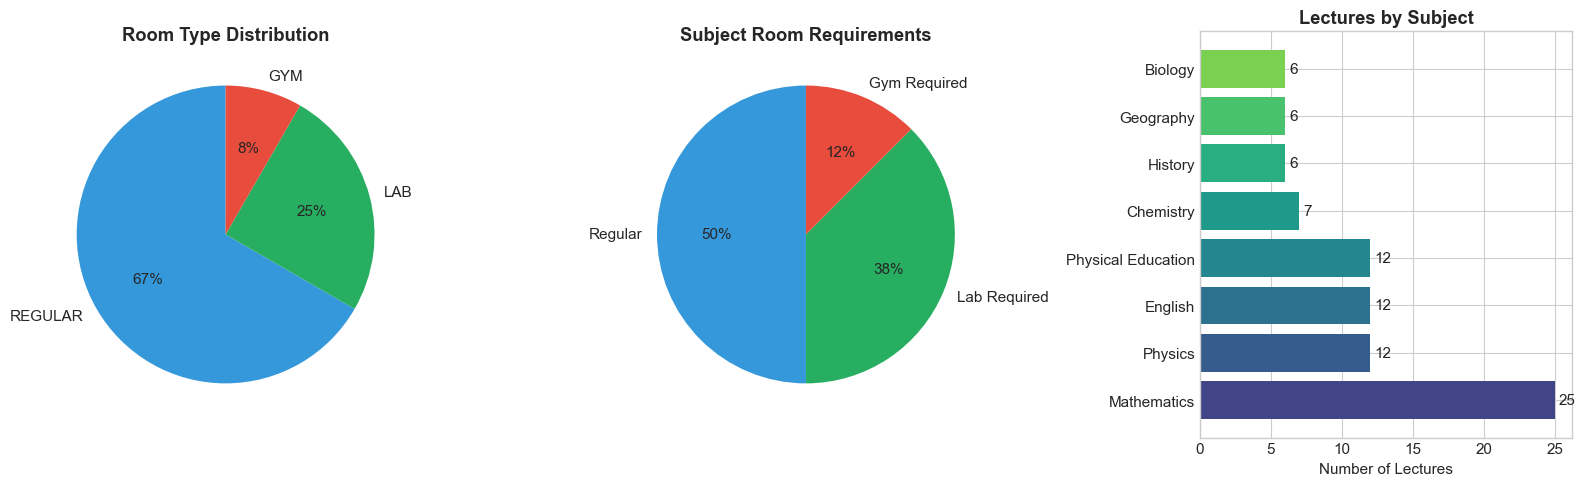

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Room type distribution
ax1 = axes[0]
room_types = {}
for r in session.query(Classroom).all():
    room_types[r.room_type] = room_types.get(r.room_type, 0) + 1

colors = {'REGULAR': '#3498db', 'LAB': '#27ae60', 'GYM': '#e74c3c'}
ax1.pie(room_types.values(), labels=room_types.keys(), colors=[colors[k] for k in room_types.keys()],
        autopct='%1.0f%%', startangle=90)
ax1.set_title('Room Type Distribution', fontweight='bold')

# Subject types (lab vs regular)
ax2 = axes[1]
lab_count = session.query(Subject).filter_by(requires_lab=True).count()
regular_count = session.query(Subject).filter_by(requires_lab=False).count() - 1  # Exclude PE
pe_count = 1

ax2.pie([regular_count, lab_count, pe_count], 
        labels=['Regular', 'Lab Required', 'Gym Required'],
        colors=['#3498db', '#27ae60', '#e74c3c'],
        autopct='%1.0f%%', startangle=90)
ax2.set_title('Subject Room Requirements', fontweight='bold')

# Lectures by subject
ax3 = axes[2]
lecture_counts = {}
for lec in session.query(Lecture).all():
    subject = session.query(Subject).filter_by(id=lec.subject_id).first()
    lecture_counts[subject.name] = lecture_counts.get(subject.name, 0) + 1

sorted_subjects = sorted(lecture_counts.items(), key=lambda x: x[1], reverse=True)
names = [s[0] for s in sorted_subjects]
counts = [s[1] for s in sorted_subjects]

bars = ax3.barh(names, counts, color=plt.cm.viridis(np.linspace(0.2, 0.8, len(names))))
ax3.set_xlabel('Number of Lectures')
ax3.set_title('Lectures by Subject', fontweight='bold')
ax3.bar_label(bars, padding=3)

plt.tight_layout()
plt.show()

## 5. Build Large-Scale Model with Room Type Constraints

In [7]:
def create_compatibility_checker(session: Session) -> callable:
    """
    Create cached compatibility checker for capacity AND room type.
    
    CRUCIAL FOR PERFORMANCE: All data is queried once and cached.
    Without caching: ~41,280 database queries
    With caching: 4 queries (classes, classrooms, subjects, lectures)
    """
    # Pre-load ALL data once (no queries inside check function!)
    class_sizes = {c.id: c.size for c in session.query(SchoolClass).all()}
    room_data = {r.id: (r.capacity, r.room_type) for r in session.query(Classroom).all()}
    subject_data = {s.id: (s.requires_lab, s.name) for s in session.query(Subject).all()}
    # Cache lecture -> (class_id, subject_id) mapping
    lecture_data = {l.id: (l.class_id, l.subject_id) for l in session.query(Lecture).all()}
    
    def check(lecture_id: int, classroom_id: int) -> bool:
        # Fast lookups from cache - NO database queries here!
        lecture_info = lecture_data.get(lecture_id)
        room_info = room_data.get(classroom_id)
        
        if lecture_info is None or room_info is None:
            return False
        
        class_id, subject_id = lecture_info
        class_size = class_sizes.get(class_id, 0)
        subject_info = subject_data.get(subject_id)
        room_capacity, room_type = room_info
        
        if subject_info is None:
            return False
        
        requires_lab, subject_name = subject_info
        
        # Check capacity
        if class_size > room_capacity:
            return False
        
        # Check room type compatibility
        # PE requires GYM
        if subject_name == "Physical Education":
            return room_type == "GYM"
        
        # Lab subjects require LAB rooms
        if requires_lab:
            return room_type == "LAB"
        
        # Regular subjects can use REGULAR or LAB (but not GYM)
        return room_type in ["REGULAR", "LAB"]
    
    return check


def calculate_priority(work_years: int) -> int:
    if work_years >= 15:
        return 1
    elif work_years >= 7:
        return 2
    return 3

In [8]:
def build_production_model(session: Session) -> Tuple[LXModel, LXVariable, dict]:
    """
    Build large-scale timetabling model with room type constraints.
    
    Returns model, assignment variable, and timing info.
    """
    timing = {}
    
    print("="*60)
    print("BUILDING LARGE-SCALE TIMETABLING MODEL")
    print("="*60)
    
    # Create cached checker
    start = time.time()
    compatibility_checker = create_compatibility_checker(session)
    timing['checker_creation'] = time.time() - start
    print(f"\nCached checker created: {timing['checker_creation']:.3f}s")
    
    # Dataset statistics
    num_lectures = session.query(Lecture).count()
    num_timeslots = session.query(TimeSlot).count()
    num_classrooms = session.query(Classroom).count()
    print(f"\nDataset: {num_lectures} lectures x {num_timeslots} slots x {num_classrooms} rooms")
    print(f"Potential variables: {num_lectures * num_timeslots * num_classrooms:,}")
    
    # Create variables
    start = time.time()
    assignment = (
        LXVariable[Tuple[Lecture, TimeSlot, Classroom], int]("assignment")
        .binary()
        .indexed_by_product(
            LXIndexDimension(Lecture, lambda lec: lec.id).from_model(session),
            LXIndexDimension(TimeSlot, lambda ts: ts.id).from_model(session),
            LXIndexDimension(Classroom, lambda room: room.id).from_model(session),
        )
        .where_multi(lambda lec, ts, room: compatibility_checker(lec.id, room.id))
    )
    timing['variable_creation'] = time.time() - start
    print(f"Variables created: {timing['variable_creation']:.3f}s")
    
    model = LXModel("timetabling_production").add_variable(assignment)
    
    # HARD CONSTRAINTS
    start = time.time()
    print("\nAdding hard constraints...")
    
    # Lecture coverage
    for lecture in session.query(Lecture).all():
        expr = LXLinearExpression().add_multi_term(
            assignment,
            coeff=lambda lec, ts, room: 1.0,
            where=lambda lec, ts, room, curr_lec=lecture: lec.id == curr_lec.id,
        )
        model.add_constraint(
            LXConstraint(f"lecture_{lecture.id}").expression(expr).eq().rhs(1)
        )
    print(f"  Lecture coverage: {session.query(Lecture).count()} constraints")

    # Room conflicts
    room_constraints = 0
    for timeslot in session.query(TimeSlot).all():
        for classroom in session.query(Classroom).all():
            expr = LXLinearExpression().add_multi_term(
                assignment,
                coeff=lambda lec, ts, room: 1.0,
                where=lambda lec, ts, room, curr_ts=timeslot, curr_room=classroom:
                    ts.id == curr_ts.id and room.id == curr_room.id,
            )
            model.add_constraint(
                LXConstraint(f"room_{classroom.id}_slot_{timeslot.id}")
                .expression(expr).le().rhs(1)
            )
            room_constraints += 1
    print(f"  Room conflicts: {room_constraints} constraints")

    # Teacher conflicts
    teacher_constraints = 0
    for teacher in session.query(Teacher).all():
        t_lecs = [l.id for l in session.query(Lecture).filter_by(teacher_id=teacher.id).all()]
        if not t_lecs:
            continue
        for timeslot in session.query(TimeSlot).all():
            expr = LXLinearExpression().add_multi_term(
                assignment,
                coeff=lambda lec, ts, room: 1.0,
                where=lambda lec, ts, room, curr_ts=timeslot, lec_ids=t_lecs:
                    ts.id == curr_ts.id and lec.id in lec_ids,
            )
            model.add_constraint(
                LXConstraint(f"teacher_{teacher.id}_slot_{timeslot.id}")
                .expression(expr).le().rhs(1)
            )
            teacher_constraints += 1
    print(f"  Teacher conflicts: {teacher_constraints} constraints")

    # Class conflicts
    class_constraints = 0
    for school_class in session.query(SchoolClass).all():
        c_lecs = [l.id for l in session.query(Lecture).filter_by(class_id=school_class.id).all()]
        if not c_lecs:
            continue
        for timeslot in session.query(TimeSlot).all():
            expr = LXLinearExpression().add_multi_term(
                assignment,
                coeff=lambda lec, ts, room: 1.0,
                where=lambda lec, ts, room, curr_ts=timeslot, lec_ids=c_lecs:
                    ts.id == curr_ts.id and lec.id in lec_ids,
            )
            model.add_constraint(
                LXConstraint(f"class_{school_class.id}_slot_{timeslot.id}")
                .expression(expr).le().rhs(1)
            )
            class_constraints += 1
    print(f"  Class conflicts: {class_constraints} constraints")
    
    timing['hard_constraints'] = time.time() - start
    
    # SOFT CONSTRAINTS (Goals)
    start = time.time()
    print("\nAdding soft goal constraints...")
    
    for pref in session.query(TeacherPreference).all():
        teacher = session.query(Teacher).filter_by(id=pref.teacher_id).first()
        priority = calculate_priority(teacher.work_years)
        
        if pref.preference_type == "DAY_OFF":
            t_lecs = [l.id for l in session.query(Lecture).filter_by(teacher_id=teacher.id).all()]
            d_slots = [ts.id for ts in session.query(TimeSlot).filter_by(day_of_week=pref.day_of_week).all()]
            
            expr = LXLinearExpression().add_multi_term(
                assignment,
                coeff=lambda lec, ts, room: 1.0,
                where=lambda lec, ts, room, lec_ids=t_lecs, slot_ids=d_slots:
                    lec.id in lec_ids and ts.id in slot_ids,
            )
            
            model.add_constraint(
                LXConstraint(f"goal_{pref.id}")
                .expression(expr).le().rhs(0)
                .as_goal(priority=priority, weight=1.0)
            )
            print(f"  [P{priority}] {teacher.name}: {DAY_NAMES[pref.day_of_week]} off")
            
        elif pref.preference_type == "SPECIFIC_TIME":
            expr = LXLinearExpression().add_multi_term(
                assignment,
                coeff=lambda lec, ts, room: 1.0,
                where=lambda lec, ts, room, target_lec=pref.lecture_id, target_ts=pref.timeslot_id:
                    lec.id == target_lec and ts.id == target_ts,
            )
            
            model.add_constraint(
                LXConstraint(f"goal_{pref.id}")
                .expression(expr).ge().rhs(1)
                .as_goal(priority=priority, weight=1.0)
            )
    
    timing['soft_constraints'] = time.time() - start
    
    model.set_goal_mode("weighted")
    
    hard = len([c for c in model.constraints if not c.is_goal()])
    soft = len([c for c in model.constraints if c.is_goal()])
    
    print(f"\n{'='*60}")
    print(f"MODEL BUILT: {hard} hard + {soft} soft = {hard+soft} total constraints")
    print(f"Total build time: {sum(timing.values()):.3f}s")
    print(f"{'='*60}")
    
    return model, assignment, timing


# Build model
model, assignment, build_timing = build_production_model(session)

BUILDING LARGE-SCALE TIMETABLING MODEL

Cached checker created: 0.001s

Dataset: 86 lectures x 40 slots x 12 rooms
Potential variables: 41,280
Variables created: 0.000s

Adding hard constraints...
  Lecture coverage: 86 constraints
  Room conflicts: 480 constraints
  Teacher conflicts: 600 constraints
  Class conflicts: 480 constraints

Adding soft goal constraints...
  [P1] Dr. Emily Watson: Thursday off
  [P1] Prof. Michael Chen: Friday off
  [P1] Dr. James Wilson: Wednesday off
  [P1] Prof. Jennifer Brown: Tuesday off
  [P2] Dr. Sarah Johnson: Friday off
  [P2] Mr. Robert Taylor: Monday off
  [P2] Dr. Patricia Martinez: Thursday off
  [P3] Ms. Rachel Green: Wednesday off
  [P3] Mr. Christopher Lee: Tuesday off

MODEL BUILT: 1646 hard + 22 soft = 1668 total constraints
Total build time: 0.017s


## 6. Solve and Analyze Performance

In [9]:
# Prepare goal programming
model.prepare_goal_programming()

# Solve
optimizer = LXOptimizer().use_solver("ortools")

print("Solving large-scale model...")
print("This may take 10-30 seconds for a problem of this size...")

solve_start = time.time()
solution = optimizer.solve(model)
solve_time = time.time() - solve_start

print(f"\n{'='*60}")
print("SOLUTION FOUND")
print(f"{'='*60}")
print(f"Status: {solution.status}")
print(f"Solve Time: {solve_time:.3f}s")

Solving large-scale model...
This may take 10-30 seconds for a problem of this size...


2025-12-12 19:39:38 - lumix.optimizer - INFO - Created model 'timetabling_production' with 45 variables and 1668 constraints
2025-12-12 19:39:38 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 19:40:16 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 1000.0000 | Time: 37.89s



SOLUTION FOUND
Status: optimal
Solve Time: 37.943s


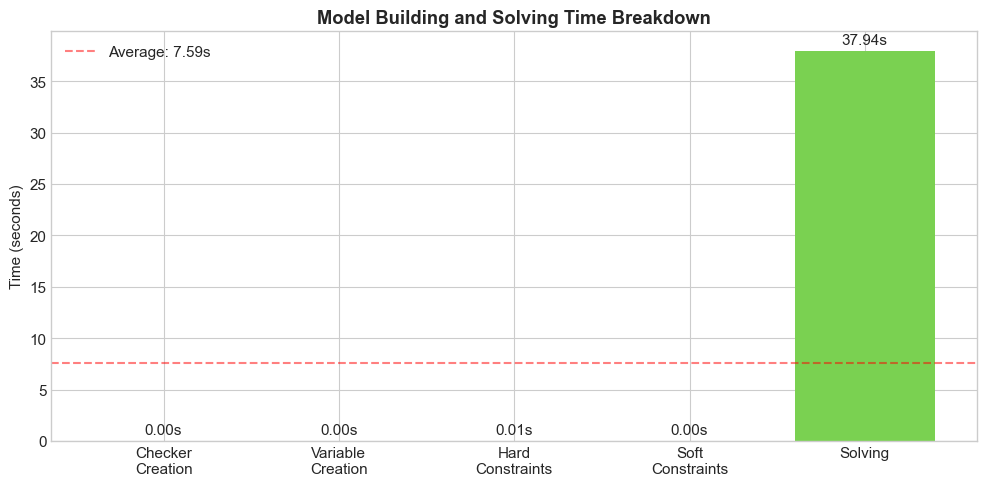


Total time: 37.96s


In [10]:
# Performance summary
fig, ax = plt.subplots(figsize=(10, 5))

phases = ['Checker\nCreation', 'Variable\nCreation', 'Hard\nConstraints', 'Soft\nConstraints', 'Solving']
times = [
    build_timing['checker_creation'],
    build_timing['variable_creation'],
    build_timing['hard_constraints'],
    build_timing['soft_constraints'],
    solve_time
]

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(phases)))
bars = ax.bar(phases, times, color=colors)
ax.set_ylabel('Time (seconds)')
ax.set_title('Model Building and Solving Time Breakdown', fontweight='bold')
ax.bar_label(bars, fmt='%.2fs', padding=3)

total = sum(times)
ax.axhline(y=total/len(phases), color='red', linestyle='--', alpha=0.5, label=f'Average: {total/len(phases):.2f}s')
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nTotal time: {total:.2f}s")

## 7. Analyze Room Type Utilization

In [11]:
# Count assignments by room type
room_usage = {'REGULAR': 0, 'LAB': 0, 'GYM': 0}

for (lecture_id, timeslot_id, classroom_id), value in solution.variables["assignment"].items():
    if value > 0.5:
        classroom = session.query(Classroom).filter_by(id=classroom_id).first()
        room_usage[classroom.room_type] += 1

print("Room Type Utilization:")
for room_type, count in room_usage.items():
    print(f"  {room_type}: {count} assignments")

total_assignments = sum(room_usage.values())
print(f"\nTotal assignments: {total_assignments}")
print(f"Expected (lectures): {session.query(Lecture).count()}")

Room Type Utilization:
  REGULAR: 42 assignments
  LAB: 32 assignments
  GYM: 12 assignments

Total assignments: 86
Expected (lectures): 86


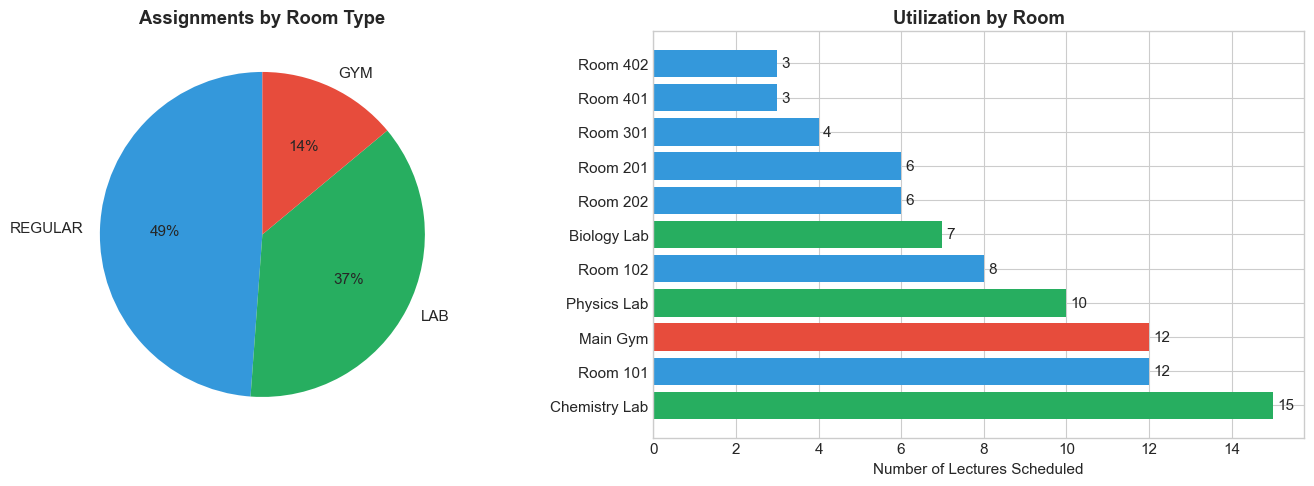

In [12]:
# Visualize room utilization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Room type usage pie
ax1 = axes[0]
colors = {'REGULAR': '#3498db', 'LAB': '#27ae60', 'GYM': '#e74c3c'}
ax1.pie(room_usage.values(), labels=room_usage.keys(), colors=[colors[k] for k in room_usage.keys()],
        autopct='%1.0f%%', startangle=90)
ax1.set_title('Assignments by Room Type', fontweight='bold')

# Individual room utilization
ax2 = axes[1]
room_individual = {}
for (lecture_id, timeslot_id, classroom_id), value in solution.variables["assignment"].items():
    if value > 0.5:
        classroom = session.query(Classroom).filter_by(id=classroom_id).first()
        room_individual[classroom.name] = room_individual.get(classroom.name, 0) + 1

# Sort by usage
sorted_rooms = sorted(room_individual.items(), key=lambda x: x[1], reverse=True)
room_names = [r[0] for r in sorted_rooms]
room_counts = [r[1] for r in sorted_rooms]

# Color by room type
room_colors = []
for name in room_names:
    room = session.query(Classroom).filter_by(name=name).first()
    room_colors.append(colors.get(room.room_type, '#95a5a6'))

bars = ax2.barh(room_names, room_counts, color=room_colors)
ax2.set_xlabel('Number of Lectures Scheduled')
ax2.set_title('Utilization by Room', fontweight='bold')
ax2.bar_label(bars, padding=3)

plt.tight_layout()
plt.show()

## 8. Sample Timetables

In [13]:
def create_teacher_timetable(session: Session, solution, teacher_id: int):
    """Create 8-period timetable grid for a teacher."""
    grid = [["" for _ in range(5)] for _ in range(8)]  # 8 periods x 5 days
    
    teacher_lectures = session.query(Lecture).filter_by(teacher_id=teacher_id).all()
    lecture_ids = [l.id for l in teacher_lectures]
    
    for (lecture_id, timeslot_id, classroom_id), value in solution.variables["assignment"].items():
        if value > 0.5 and lecture_id in lecture_ids:
            lecture = session.query(Lecture).filter_by(id=lecture_id).first()
            timeslot = session.query(TimeSlot).filter_by(id=timeslot_id).first()
            classroom = session.query(Classroom).filter_by(id=classroom_id).first()
            subject = session.query(Subject).filter_by(id=lecture.subject_id).first()
            school_class = session.query(SchoolClass).filter_by(id=lecture.class_id).first()
            
            # Abbreviate subject name
            subj_abbrev = subject.name[:4] if len(subject.name) > 4 else subject.name
            cell = f"{subj_abbrev}\n{school_class.name}\n{classroom.name[:8]}"
            grid[timeslot.period - 1][timeslot.day_of_week] = cell
    
    return grid


def plot_timetable(grid, title):
    """Plot 8-period timetable."""
    fig, ax = plt.subplots(figsize=(14, 10))
    
    for i in range(8):
        for j in range(5):
            color = '#e8f4f8' if grid[i][j] else '#f5f5f5'
            ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, facecolor=color, edgecolor='gray'))
    
    for i in range(8):
        for j in range(5):
            if grid[i][j]:
                ax.text(j, i, grid[i][j], ha='center', va='center', fontsize=8,
                       bbox=dict(boxstyle='round', facecolor='#3498db', alpha=0.7),
                       color='white', fontweight='bold')
    
    ax.set_xlim(-0.5, 4.5)
    ax.set_ylim(7.5, -0.5)
    ax.set_xticks(np.arange(5))
    ax.set_yticks(np.arange(8))
    ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
    ax.set_yticklabels([f'Period {i+1}' for i in range(8)])
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    return fig

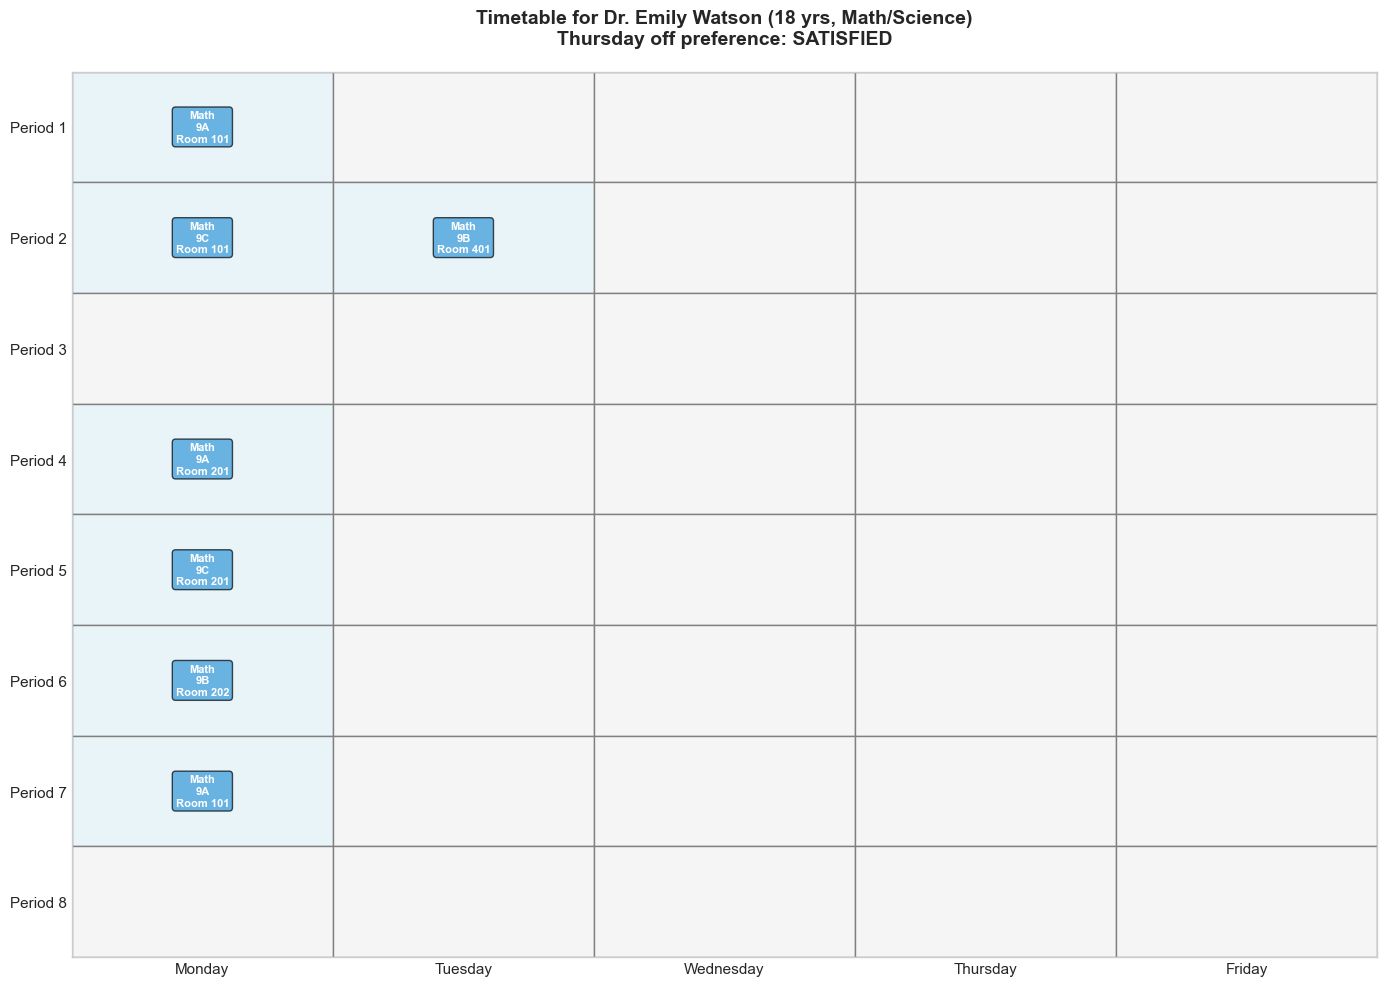

In [14]:
# Plot timetable for Dr. Watson (wants Thursday off)
teacher = session.query(Teacher).filter_by(id=1).first()
grid = create_teacher_timetable(session, solution, teacher.id)

thursday_lectures = sum(1 for cell in [grid[p][3] for p in range(8)] if cell)
status = "SATISFIED" if thursday_lectures == 0 else f"VIOLATED ({thursday_lectures} lectures)"

fig = plot_timetable(grid, f"Timetable for {teacher.name} ({teacher.work_years} yrs, {teacher.department})\nThursday off preference: {status}")
plt.show()

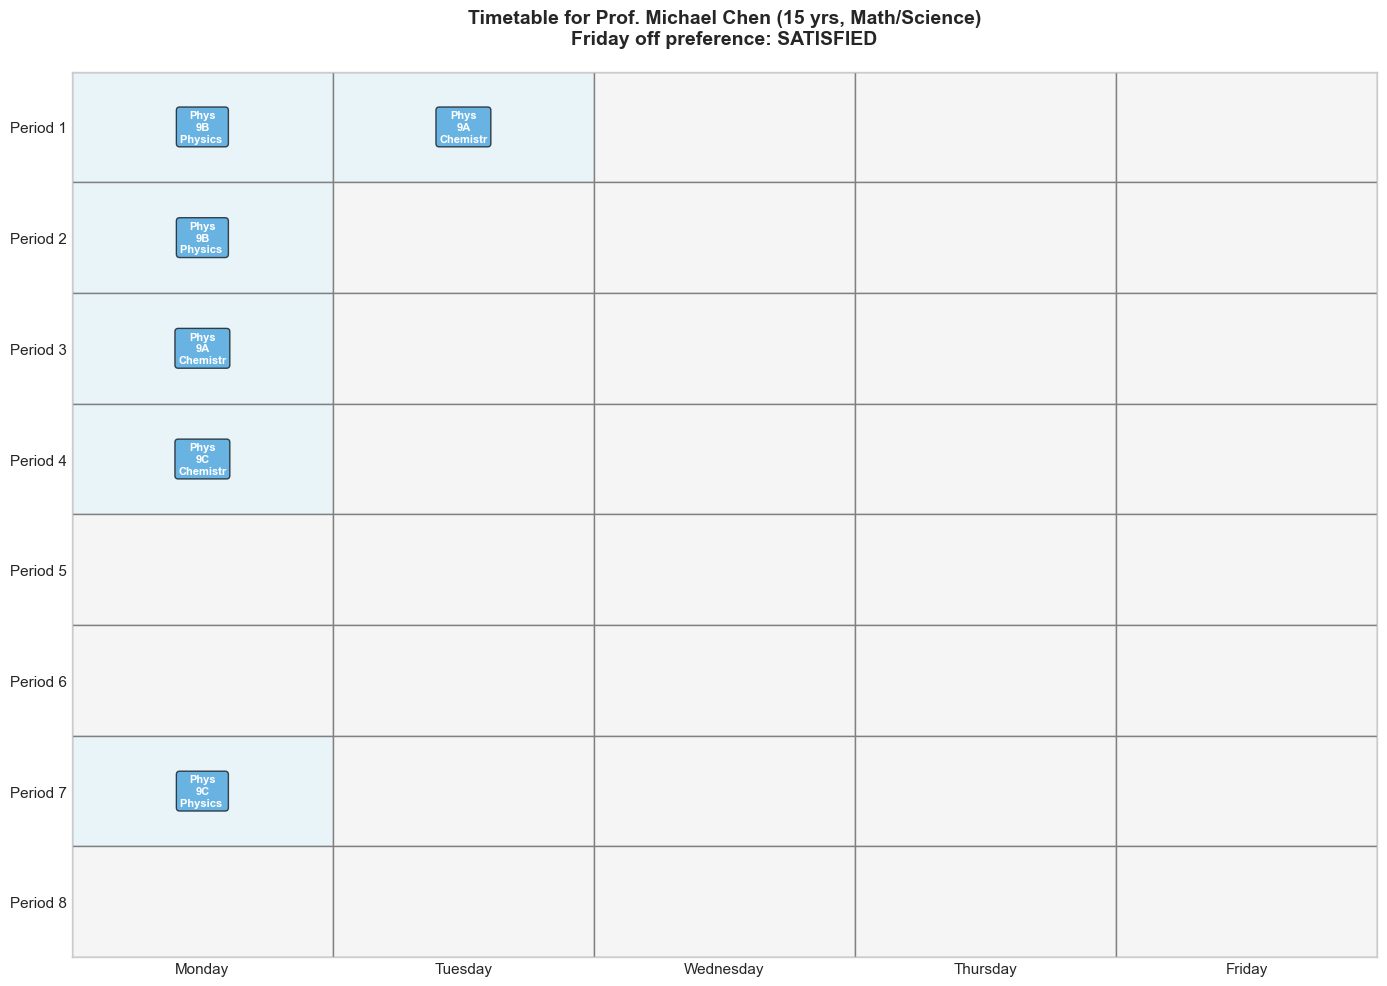

In [15]:
# Plot timetable for Prof. Chen (wants Friday off)
teacher = session.query(Teacher).filter_by(id=2).first()
grid = create_teacher_timetable(session, solution, teacher.id)

friday_lectures = sum(1 for cell in [grid[p][4] for p in range(8)] if cell)
status = "SATISFIED" if friday_lectures == 0 else f"VIOLATED ({friday_lectures} lectures)"

fig = plot_timetable(grid, f"Timetable for {teacher.name} ({teacher.work_years} yrs, {teacher.department})\nFriday off preference: {status}")
plt.show()

## 9. Key Insights

### What We Learned

1. **Scaling Efficiently**: LumiX handles large-scale problems well. Key factors:
   - **Cached compatibility checkers** avoid redundant DB queries
   - `where_multi()` filtering reduces variable count before model building
   - Pre-loading data into dictionaries provides O(1) lookups

2. **Room Type Constraints**: Easy to model specialized room requirements:
   ```python
   if subject_name == "Physical Education":
       return room_type == "GYM"
   if requires_lab:
       return room_type == "LAB"
   ```

3. **Performance Tips**:
   - **Cache everything** - No DB queries inside filter functions
   - **Filter early** - Use `where_multi()` to reduce variable count
   - **Use default arguments** in lambdas to avoid closure bugs

4. **Goal Programming at Scale**: Works well even with many constraints

### Pattern: Cached Compatibility Checker

```python
def create_cached_checker(session):
    # Pre-load ALL data once (4 queries total)
    classes = {c.id: c.size for c in session.query(SchoolClass).all()}
    rooms = {r.id: (r.capacity, r.room_type) for r in ...}
    subjects = {s.id: (s.requires_lab, s.name) for s in ...}
    lectures = {l.id: (l.class_id, l.subject_id) for l in ...}
    
    def check(lecture_id, classroom_id) -> bool:
        # Fast dictionary lookups only - NO database queries!
        return ...
    
    return check
```

## 10. Extensions & Exercises

1. **Even larger scale**: 30 teachers, 20 classrooms, 200 lectures
2. **Multiple room types**: Computer labs, music rooms, art studios
3. **Equipment constraints**: Projectors, smart boards, lab equipment
4. **Multi-campus**: Different buildings with travel time between them
5. **Export to calendar**: Generate iCal files for teachers and students

**Congratulations!** You've completed the High School Timetabling tutorial series.

In [16]:
# Cleanup
session.close()
print("Session closed.")
print("\nTutorial complete!")

Session closed.

Tutorial complete!
